In [ ]:
# 1.1 Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from itertools import cycle

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# 1.2 Data Loading
# Assuming 'xAPI-Edu-Data.csv' is uploaded to your Colab environment
df = pd.read_csv('xAPI-Edu-Data.csv')

# 1.3 Initial Data Inspection (Dataset Description)
print("--- Initial 5 Rows ---")
print(df.head())
print("\n--- Column Information and Data Types ---")
df.info()
print("\n--- Descriptive Statistics ---")
print(df.describe())

--- Initial 5 Rows ---
  gender NationalITy PlaceofBirth     StageID GradeID SectionID Topic  \
0      M          KW       KuwaIT  lowerlevel    G-04         A    IT   
1      M          KW       KuwaIT  lowerlevel    G-04         A    IT   
2      M          KW       KuwaIT  lowerlevel    G-04         A    IT   
3      M          KW       KuwaIT  lowerlevel    G-04         A    IT   
4      M          KW       KuwaIT  lowerlevel    G-04         A    IT   

  Semester Relation  raisedhands  VisITedResources  AnnouncementsView  \
0        F   Father           15                16                  2   
1        F   Father           20                20                  3   
2        F   Father           10                 7                  0   
3        F   Father           30                25                  5   
4        F   Father           40                50                 12   

   Discussion ParentAnsweringSurvey ParentschoolSatisfaction  \
0          20                   Yes

In [ ]:
# 2.1 Clean Column Names
# Rename misspelled or awkward columns for easier access
df.rename(columns={'NationalITy':'Nationality', 'raisedhands':'RaisedHands',
                   'VisITedResources':'VisitedResources', 'AnnouncementsView':'AnnouncementsViews',
                   'ParentAnsweringSurvey':'ParentSurvey', 'ParentschoolSatisfaction':'ParentSatisfaction',
                   'StudentAbsenceDays':'AbsenceDays'}, inplace=True)

# 2.2 Target Encoding
# Convert the ordinal target variable (L, M, H) into numerical indices (0, 1, 2)
class_mapping = {'L': 0, 'M': 1, 'H': 2}
df['Class_Encoded'] = df['Class'].map(class_mapping)

# Separate features (X) and target (y)
X = df.drop(['Class', 'Class_Encoded'], axis=1)
y = df['Class_Encoded']

# One-hot encode the target for Deep Learning (Keras requirement for multi-class)
y_onehot = to_categorical(y, num_classes=3)

# 2.3 Feature Categorization
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numerical_cols = X.select_dtypes(exclude='object').columns.tolist()

# 2.4 Data Preprocessing Pipeline (ColumnTransformer)
# 1. Scale all numerical features (StandardScaler)
# 2. One-Hot Encode all categorical features (OneHotEncoder)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough' # Keep any columns not specified
)

# Apply preprocessing and split data
X_processed = preprocessor.fit_transform(X)

# Get the final input shape for the Deep Learning model
input_shape = X_processed.shape[1]
print(f"\nFinal feature count after preprocessing: {input_shape}")

# 2.5 Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_onehot, test_size=0.2, random_state=42, stratify=y
)

print(f"Training samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")


Final feature count after preprocessing: 72
Training samples: 384, Test samples: 96


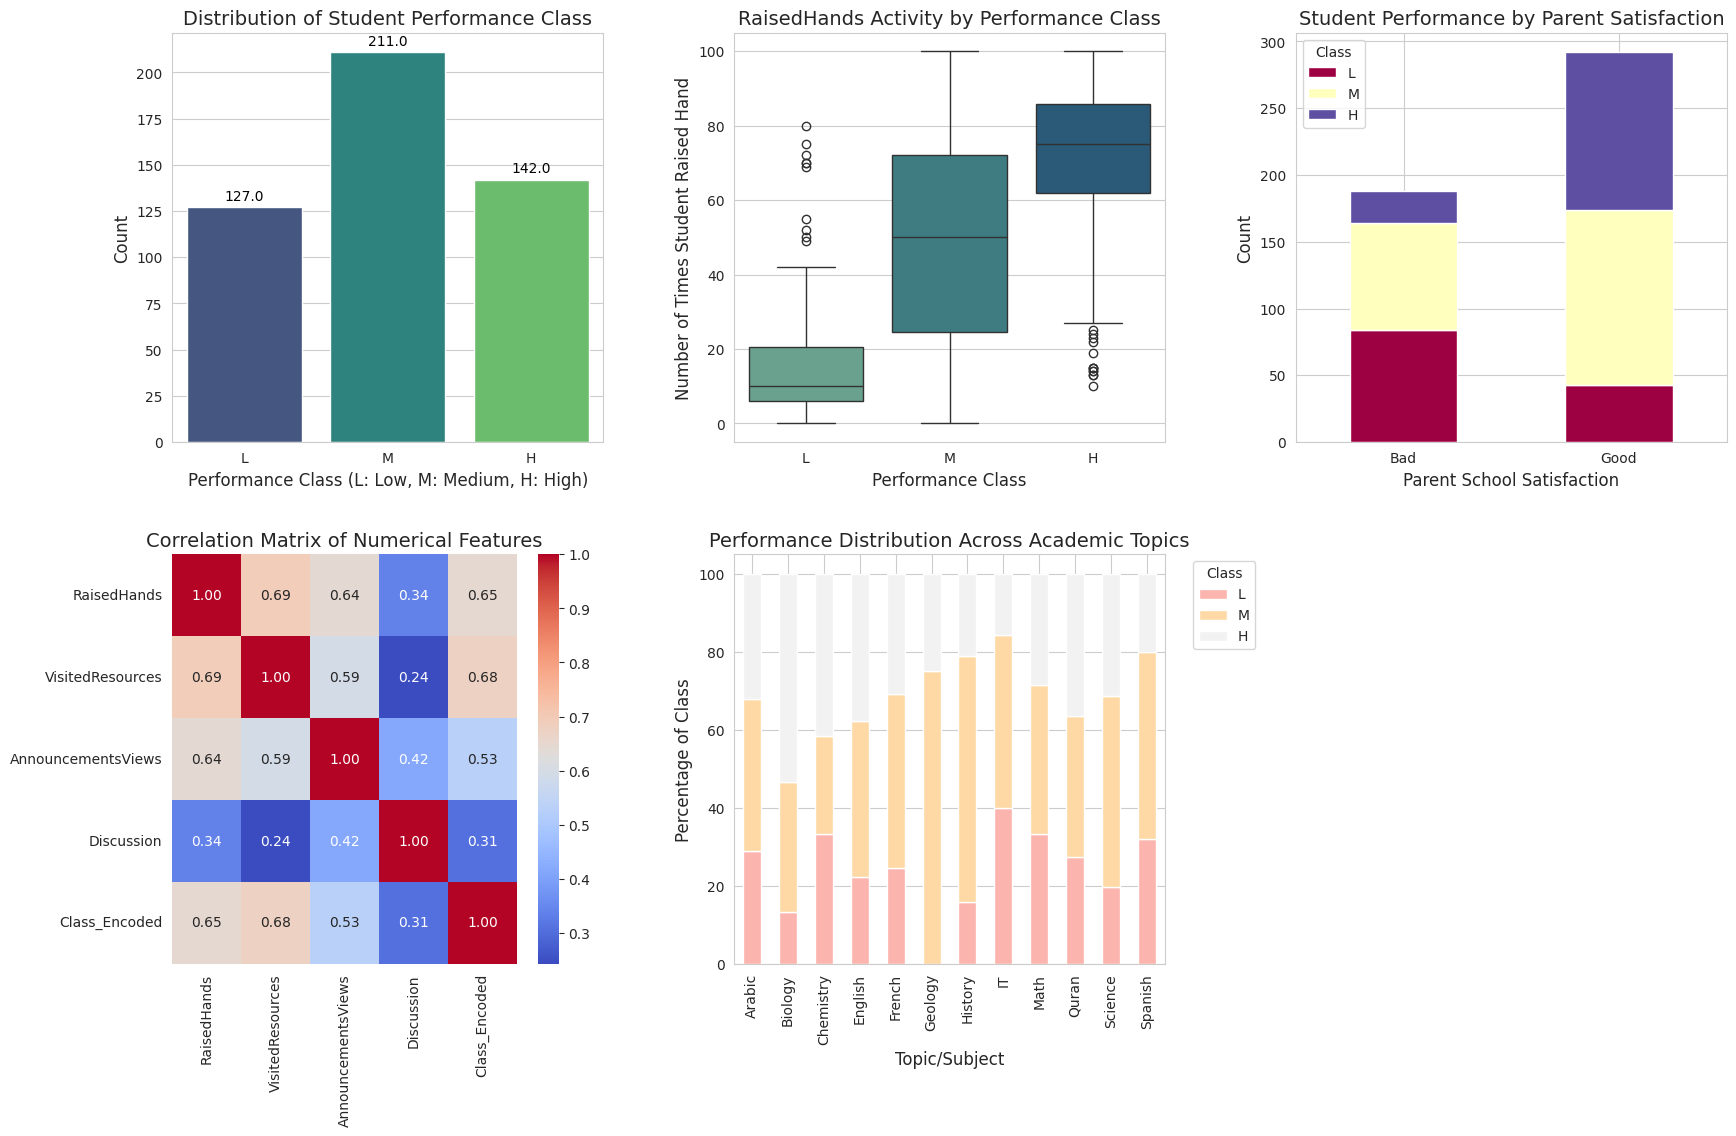

In [ ]:
plt.figure(figsize=(18, 12))
sns.set_style('whitegrid')

# 3.1 Visual 1: Distribution of Student Performance (Target Variable)
plt.subplot(2, 3, 1)
ax = sns.countplot(x='Class', data=df, order=['L', 'M', 'H'], palette='viridis')
plt.title('Distribution of Student Performance Class', fontsize=14)
plt.xlabel('Performance Class (L: Low, M: Medium, H: High)', fontsize=12)
plt.ylabel('Count', fontsize=12)
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')


# 3.2 Visual 2: Box Plot of 'RaisedHands' vs. Student Performance
plt.subplot(2, 3, 2)
sns.boxplot(x='Class', y='RaisedHands', data=df, order=['L', 'M', 'H'], palette='crest')
plt.title('RaisedHands Activity by Performance Class', fontsize=14)
plt.xlabel('Performance Class', fontsize=12)
plt.ylabel('Number of Times Student Raised Hand', fontsize=12)

# 3.3 Visual 3: Performance vs. Parent Satisfaction (Stacked Bar Plot)
plt.subplot(2, 3, 3)
satisfaction_counts = df.groupby(['ParentSatisfaction', 'Class']).size().unstack(fill_value=0)
satisfaction_counts = satisfaction_counts[['L', 'M', 'H']] # Ensure order L, M, H
satisfaction_counts.plot(kind='bar', stacked=True, colormap='Spectral', ax=plt.gca())
plt.title('Student Performance by Parent Satisfaction', fontsize=14)
plt.xlabel('Parent School Satisfaction', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Class')

# 3.4 Visual 4: Correlation Heatmap of Key Numerical Features
plt.subplot(2, 3, 4)
numerical_corr = df[numerical_cols + ['Class_Encoded']].corr()
sns.heatmap(numerical_corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix of Numerical Features', fontsize=14)
plt.yticks(rotation=0)

# 3.5 Visual 5: Performance across Different Topics (Unique Output)
plt.subplot(2, 3, 5)
topic_class_counts = pd.crosstab(df['Topic'], df['Class'], normalize='index') * 100
topic_class_counts = topic_class_counts[['L', 'M', 'H']]
topic_class_counts.plot(kind='bar', stacked=True, colormap='Pastel1', ax=plt.gca())
plt.title('Performance Distribution Across Academic Topics', fontsize=14)
plt.xlabel('Topic/Subject', fontsize=12)
plt.ylabel('Percentage of Class', fontsize=12)
plt.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout(pad=3.0)
plt.show()

In [ ]:
# 4.1 Model Architecture
model = Sequential([
    # Input Layer (Input shape is determined by the preprocessed data)
    Dense(128, activation='relu', input_shape=(input_shape,)),
    # Dropout to prevent overfitting (Hyperparameter)
    Dropout(0.3),

    # Second Hidden Layer
    Dense(64, activation='relu'),
    # Dropout (Hyperparameter)
    Dropout(0.3),

    # Third Hidden Layer
    Dense(32, activation='relu'),

    # Output Layer (3 units for 3 classes L, M, H)
    # Softmax activation for multi-class probability distribution
    Dense(3, activation='softmax')
])

# 4.2 Compile the Model (Training Parameters)
model.compile(
    # Optimizer (Training parameter)
    optimizer='adam',
    # Loss function for multi-class classification with one-hot encoding
    loss='categorical_crossentropy',
    # Metric to monitor during training
    metrics=['accuracy']
)

print("--- Model Summary (Architecture) ---")
model.summary()

# 4.3 Train the Model (Hyperparameters)
history = model.fit(
    X_train, y_train,
    epochs=50,          # Number of Epochs (Hyperparameter)
    batch_size=32,      # Batch Size (Hyperparameter)
    validation_split=0.1, # Use 10% of training data for validation
    verbose=1           # Show training progress
)

--- Model Summary (Architecture) ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         9,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,779 (77.26 KB)

 Trainable params: 19,779 (77.26 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.4372 - loss: 1.0745 - val_accuracy: 0.6154 - val_loss: 0.9781
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6261 - loss: 0.8785 - val_accuracy: 0.6154 - val_loss: 0.8636
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6211 - loss: 0.8087 - val_accuracy: 0.6410 - val_loss: 0.8080
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6732 - loss: 0.7035 - val_accuracy: 0.6923 - val_loss: 0.7808
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6855 - loss: 0.6011 - val_accuracy: 0.6667 - val_loss: 0.7920
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7446 - loss: 0.5864 - val_accuracy: 0.7179 - val_loss: 0.8004
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7802 - loss: 0.5381 - val_accuracy: 0.6667 - val_loss: 0.8280
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7605 - loss: 0.5491 - val_accuracy: 0.7436 - v


--- Model Evaluation on Test Set ---
Test Loss: 1.0876
Test Accuracy: 0.6979
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


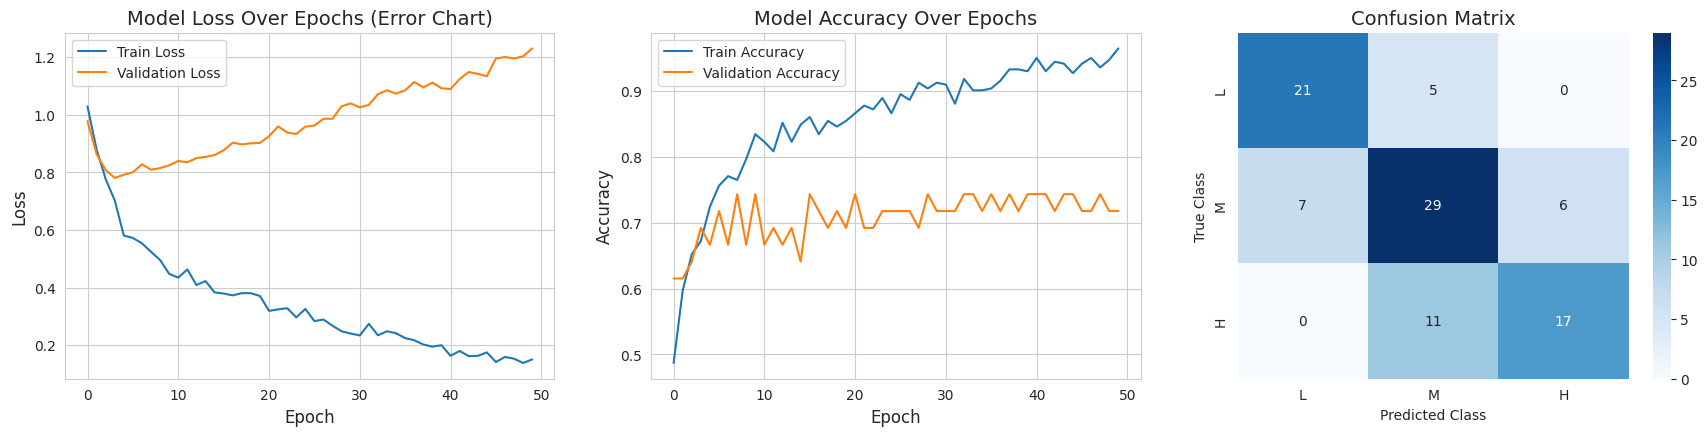


--- Classification Report (Precision, Recall, F1-Score) ---
              precision    recall  f1-score   support

     Low (L)       0.75      0.81      0.78        26
  Medium (M)       0.64      0.69      0.67        42
    High (H)       0.74      0.61      0.67        28

    accuracy                           0.70        96
   macro avg       0.71      0.70      0.70        96
weighted avg       0.70      0.70      0.70        96



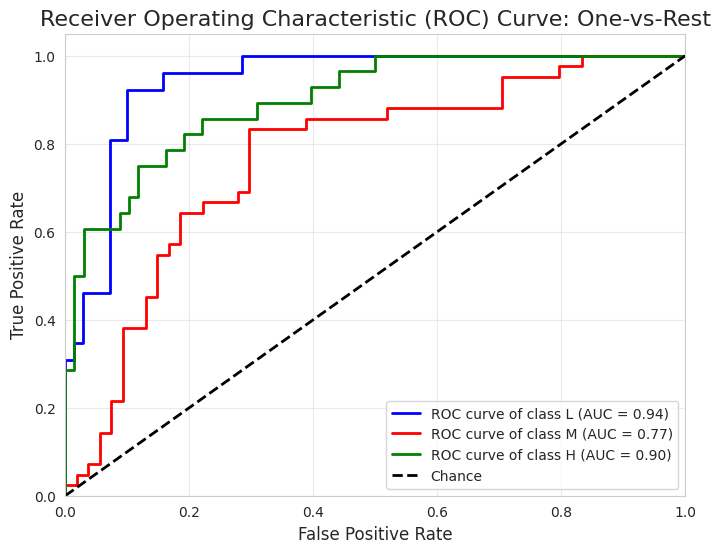

In [ ]:
# 5.1 Model Evaluation
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\n--- Model Evaluation on Test Set ---")
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Get predictions
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1) # Predicted class index
y_true = np.argmax(y_test, axis=1)       # True class index
target_names = ['Low (L)', 'Medium (M)', 'High (H)']

plt.figure(figsize=(18, 5))

# 5.2 Output 1: Training History (Error/Loss and Accuracy Charts)
# Loss Chart
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs (Error Chart)', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()

# Accuracy Chart
plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()

# 5.3 Output 2: Confusion Matrix Heatmap
plt.subplot(1, 3, 3)
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['L', 'M', 'H'], yticklabels=['L', 'M', 'H'])
plt.title('Confusion Matrix', fontsize=14)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')

plt.tight_layout(pad=3.0)
plt.show()

# 5.4 Output 3: Classification Report (Interpretation)
print("\n--- Classification Report (Precision, Recall, F1-Score) ---")
print(classification_report(y_true, y_pred, target_names=target_names))

# 5.5 Output 4 (Unique): ROC Curve and AUC (One-vs-Rest)
# Compute ROC curve and ROC area for each class
n_classes = y_onehot.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
class_labels = ['L', 'M', 'H']

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting the One-vs-Rest ROC Curve
plt.figure(figsize=(8, 6))
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {class_labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve: One-vs-Rest', fontsize=16)
plt.legend(loc="lower right")
plt.grid(alpha=0.4)
plt.show()


--- 2.1 Deeper EDA: Numerical Feature Importance (ANOVA F-Test) ---
              Feature     F_Value       P_Value  Is_Significant
1    VisitedResources  230.472972  9.166968e-71            True
0         RaisedHands  176.389079  4.510210e-58            True
2  AnnouncementsViews   98.725200  1.324507e-36            True
3          Discussion   25.253049  3.761649e-11            True


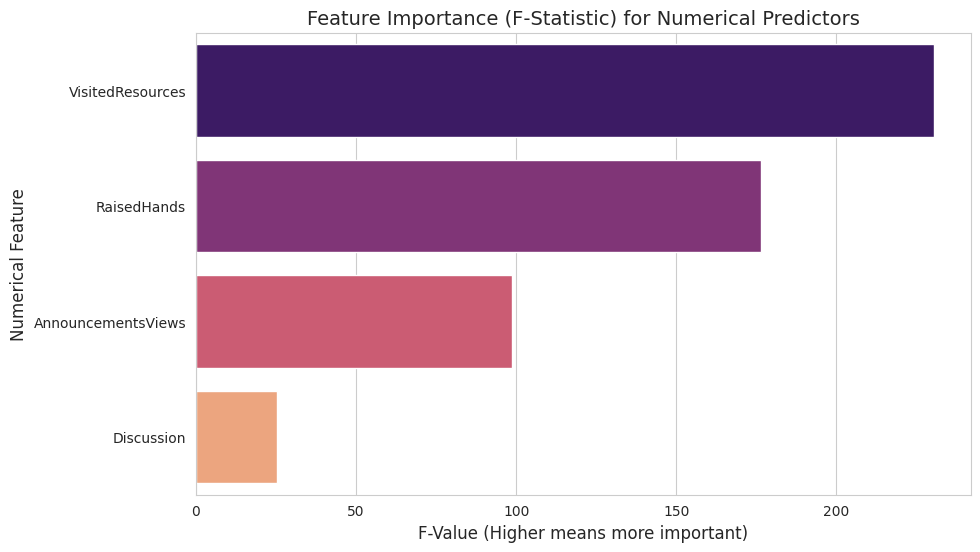

In [ ]:
print("\n--- 2.1 Deeper EDA: Numerical Feature Importance (ANOVA F-Test) ---")
# Select only numerical features and the encoded target
X_num = df[numerical_cols]
y_simple = df['Class_Encoded']

# Calculate F-statistics and p-values
f_values, p_values = f_classif(X_num, y_simple)

feature_importance_df = pd.DataFrame({
    'Feature': numerical_cols,
    'F_Value': f_values,
    'P_Value': p_values
}).sort_values(by='P_Value')

# Check for statistical significance (p < 0.05)
feature_importance_df['Is_Significant'] = feature_importance_df['P_Value'] < 0.05
print(feature_importance_df)

# Visualize the F-values (Unique Output)
plt.figure(figsize=(10, 6))
sns.barplot(x='F_Value', y='Feature', data=feature_importance_df.sort_values(by='F_Value', ascending=False), palette='magma')
plt.title('Feature Importance (F-Statistic) for Numerical Predictors', fontsize=14)
plt.xlabel('F-Value (Higher means more important)', fontsize=12)
plt.ylabel('Numerical Feature', fontsize=12)
plt.savefig('eda_f_value_importance.png')
plt.show()

# Insight: Features like RaisedHands, VisitedResources, and AnnouncementsViews show very high F-values
# and extremely low P-values, confirming they are statistically highly significant predictors of 'Class'.